Compare northward water flux from model and pressure levels with the northward warter flux from ERA5

In [22]:
import os

import pandas as pd
import xarray as xr
import yaml
import numpy as np
import matplotlib.pyplot as plt

def load_surface_data(variable, date):
    """Load data for given variable and date."""
    filename = f"FloodCase_201305_{variable}.nc"
    filepath = os.path.join(input_folder, filename)
    da = xr.open_dataset(filepath)[variable]

    # Include midnight of the next day (if available)
    extra = date + pd.Timedelta(days=1)
    return da.sel(time=slice(date, extra))

def load_modellevel_data(variable, date):
    """Load model level data for given variable and date."""
    filename = f"FloodCase_201305_ml_{variable}.nc"
    filepath = os.path.join(input_folder, filename)
    da = xr.open_dataset(filepath)[variable]

    # Include midnight of the next day (if available)
    extra = date + pd.Timedelta(days=1)
    return da.sel(time=slice(date, extra)).sel(lev=modellevels)

def load_data(variable, date):
    """Load data for given variable and date."""
    filename = f"FloodCase_201305_{variable}.nc"
    filepath = os.path.join(input_folder, filename)
    da = xr.open_dataset(filepath)[variable]

    # Include midnight of the next day (if available)
    extra = date + pd.Timedelta(days=1)
    return da.sel(time=slice(date, extra))


In [49]:
start_date = '20130521'
end_date = '20130604'

datelist = pd.date_range(
    start=start_date, end=end_date, freq="d", inclusive="left"
)

input_folder = '../data/volume_2/era5_2013'

modellevels = list(np.arange(1,138,1))# + list(np.arange(91,138)) #[1,20,40,60,80,100,105,110,115,120,125,126,127,128,129,130,131,132,133,134,135,136,137]
print(modellevels)
print('how many modellevels: ' + str(len(modellevels)))
g = 9.80665  # [m/s2]

for date in datelist[:1]:
    print(date)

    # Load data
    u_ml = load_modellevel_data("u", date).sel(lev=modellevels).isel(time=0)
    v_ml = load_modellevel_data("v", date).sel(lev=modellevels).isel(time=0)
    q_ml = load_modellevel_data("q", date).sel(lev=modellevels).isel(time=0)
    ml = q_ml.lev
    sp = load_surface_data("sp", date).isel(time=0)
    tcw = load_surface_data("tcw", date).isel(time=0) # kg/m2
    vinwv = load_surface_data("vinwv", date).isel(time=0) # kg/m2
    viewv = load_surface_data("viewv", date).isel(time=0) # kg/m2
    u_pl = load_data("u", date).isel(time=0)
    v_pl = load_data("v", date).isel(time=0)
    q_pl = load_data("q", date).isel(time=0)
    
    # change modellevels to pressure levels
    filenamecsv = 'tableERA5model_to_pressure.csv'
    df = pd.read_csv(os.path.join(input_folder,filenamecsv))
    a = df['a [Pa]'].to_xarray().rename(index='lev').sel(lev=modellevels)
    b = df['b'].to_xarray().rename(index='lev').sel(lev=modellevels) 
    sp_modellevels2 = sp.expand_dims({'lev':modellevels})#,axis=1)
    p_modellevels = a + b*sp_modellevels2 # in Pa
    dp_modellevels = p_modellevels.diff(dim="lev")
    
    #interpolate and calculate dp on pressure levels
    # Create pressure array
    levels = q_pl.level
    p = levels.broadcast_like(u_pl)*100  # Pa
   
    # Interpolate to new levels
    edges = 0.5 * (levels.values[1:] + levels.values[:-1])
    u_pl_edges = u_pl.interp(level=edges)
    v_pl_edges = v_pl.interp(level=edges)
    q_pl_edges = q_pl.interp(level=edges)
    # Calculate pressure jump
    dp = p.diff(dim="level") 
    dp["level"] = edges
    #but still take into account mountains here!!!
    
    # Split in 2 layers
    P_boundary = 0.72878581 * sp + 7438.803223
    lower_layer = (dp.level < sp / 100) & (dp.level > P_boundary / 100)
    upper_layer = dp.level < P_boundary / 100
    total_layer = upper_layer + lower_layer
   
    #calculate column water vapour from model levels and pressure levels
    cwv_ml = (q_ml * dp_modellevels / g).sum(dim='lev')   # column water vapor (kg/m2)      
    cwv_pl_edges      = (q_pl_edges * dp / g).where(total_layer).sum(dim='level')   # column water vapor (kg/m2) upper layer
    q_pl_edges_update = q_pl_edges.where(total_layer)
    
    fa_e_ml = (u_ml * q_ml * dp_modellevels / g).sum(dim='lev')  # eastward atmospheric moisture flux at model levels
    fa_n_ml = (v_ml * q_ml * dp_modellevels / g).sum(dim='lev')  # northward atmospheric moisture flux at model levels
    
    fa_e_ml_update = q_ml * u_ml 
    fa_n_ml_update = q_ml * v_ml
    
    fa_e_pl_edges = (q_pl_edges * u_pl_edges * dp / g).where(total_layer).sum(dim='level') # eastward atmospheric moisture flux at pressure levels
    fa_n_pl_edges = (q_pl_edges * v_pl_edges * dp / g).where(total_layer).sum(dim='level') # northward atmospheric moisture flux at pressure levels
    
    fa_e_pl_edges_update = (q_pl_edges * u_pl_edges).where(total_layer)
    fa_n_pl_edges_update = (q_pl_edges * v_pl_edges).where(total_layer)
    

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137]
how many modellevels: 137
2013-05-21 00:00:00


In [50]:
print(lower_layer[:,60,225])
print(P_boundary[60,225])
print(sp[60,225])


<xarray.DataArray (level: 10)>
array([False, False, False, False, False,  True, False, False, False,
       False])
Coordinates:
    time       datetime64[ns] 2013-05-21
  * level      (level) float64 250.0 350.0 450.0 550.0 ... 875.0 925.0 975.0
    longitude  float32 6.25
    latitude   float32 45.0
<xarray.DataArray 'sp' ()>
array(65730.45, dtype=float32)
Coordinates:
    time       datetime64[ns] 2013-05-21
    longitude  float32 6.25
    latitude   float32 45.0
<xarray.DataArray 'sp' ()>
array(79984.62, dtype=float32)
Coordinates:
    time       datetime64[ns] 2013-05-21
    longitude  float32 6.25
    latitude   float32 45.0
Attributes:
    standard_name:  surface_air_pressure
    long_name:      Surface pressure
    units:          Pa


Text(0.5, 1.0, 'Diff between ERA5 vinwv and fa_n at 12 pressure levels')

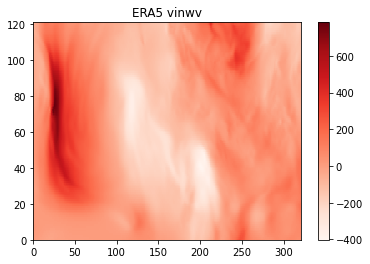

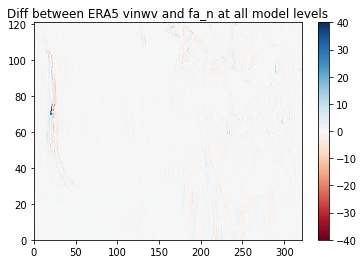

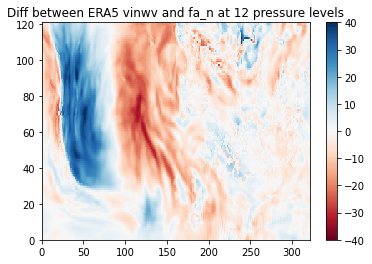

In [51]:
#spatial plot

fig, axs = plt.subplots(1)
var1 = axs.pcolor(vinwv,cmap = plt.cm.Reds)
plt.colorbar(var1)
axs.set_title('ERA5 vinwv')

fig, axs = plt.subplots(1)
var1 = axs.pcolor(vinwv - fa_n_ml, cmap=plt.cm.RdBu, vmin =-40, vmax=40)
plt.colorbar(var1)
axs.set_title('Diff between ERA5 vinwv and fa_n at all model levels')

fig1, axs1 = plt.subplots(1)
var2 = axs1.pcolor(vinwv - fa_n_pl_edges, cmap = plt.cm.RdBu, vmin =-40, vmax=40)
plt.colorbar(var2)
axs1.set_title('Diff between ERA5 vinwv and fa_n at 12 pressure levels')


Text(0.5, 1.0, 'Percentage diff between ERA5 vinwv and fa_n at 12 pressure levels')

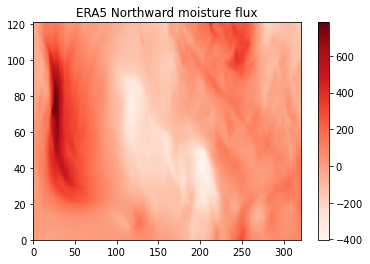

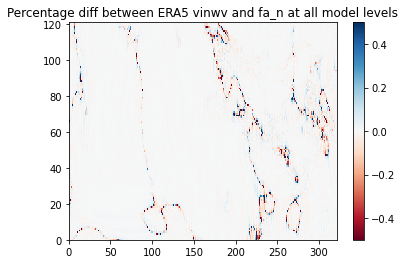

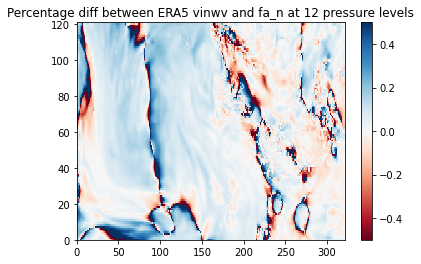

In [63]:
#spatial plot

fig, axs = plt.subplots(1)
var1 = axs.pcolor(vinwv,cmap = plt.cm.Reds)
plt.colorbar(var1)
axs.set_title('ERA5 Northward moisture flux')

fig, axs = plt.subplots(1)
var1 = axs.pcolor((vinwv - fa_n_ml)/vinwv, cmap=plt.cm.RdBu, vmin =-.5, vmax=.5)
plt.colorbar(var1)
axs.set_title('Percentage diff between ERA5 vinwv and fa_n at all model levels')

fig1, axs1 = plt.subplots(1)
var2 = axs1.pcolor((vinwv - fa_n_pl_edges)/vinwv, cmap = plt.cm.RdBu, vmin =-.5, vmax=.5)
plt.colorbar(var2)
axs1.set_title('Percentage diff between ERA5 vinwv and fa_n at 12 pressure levels')

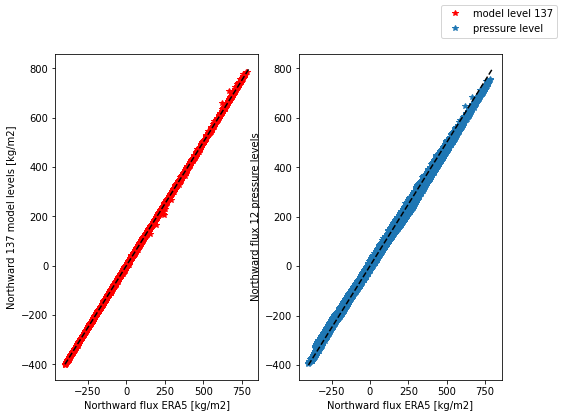

In [53]:
#scatter plot

fig, axs = plt.subplots(1,2, figsize=(8, 6))

axs[0].plot(vinwv.values.flatten(), fa_n_ml.values.flatten(), 'r*', label = 'model level 137')
axs[0].set_xlabel('Northward flux ERA5 [kg/m2]')
axs[0].set_ylabel('Northward 137 model levels [kg/m2]')
axs[0].plot(np.arange(-400,800),np.arange(-400,800),'k--')

axs[1].plot(vinwv.values.flatten(), fa_n_pl_edges.values.flatten(), '*', label='pressure level')
axs[1].set_xlabel('Northward flux ERA5 [kg/m2]')
axs[1].set_ylabel('Northward flux 12 pressure levels')
axs[1].plot(np.arange(-400,800),np.arange(-400,800),'k--')

fig.legend()

In [54]:
print('Max difference between ERA5 and model levels:' + str((vinwv.values.flatten() - fa_n_ml.values.flatten()).max()))
print('Max difference between ERA5 and pressure levels:' + str((vinwv.values.flatten() - fa_n_pl_edges.values.flatten()).max()))

Max difference between ERA5 and model levels:39.66833599397856
Max difference between ERA5 and pressure levels:42.16552699051388


In [55]:
fa_n_ml_update[1:,0,0]

<xarray.DataArray (lev: 136)>
array([-2.4101255e-05, -2.7335333e-05, -3.0457217e-05, -3.1004351e-05,
       -3.9388378e-05, -4.6814926e-05, -3.7626287e-05, -2.4205401e-05,
       -2.1292717e-05, -2.4800813e-05, -2.9797438e-05, -3.3852670e-05,
       -4.1665426e-05, -5.2181673e-05, -4.7666072e-05, -3.5095571e-05,
       -1.6553882e-05, -6.3975776e-06, -5.2396681e-06, -2.7876247e-06,
       -1.0318402e-06, -3.5065877e-06, -1.0522157e-05, -1.5411108e-05,
       -1.3579643e-05, -1.1135168e-05, -1.3594779e-05, -1.3329899e-05,
       -9.3793842e-06, -5.9367349e-06,  2.0394896e-06,  8.8742272e-06,
        8.6713699e-06,  5.7360871e-06,  4.2023353e-06,  5.8180635e-06,
        8.0381888e-06,  7.2470389e-06,  4.1376384e-06,  3.2054313e-06,
        3.4023055e-06,  4.8499555e-06,  6.4955252e-06,  5.5228861e-06,
        4.5219717e-06,  5.5568153e-06,  5.4097886e-06,  3.5436778e-06,
        3.6789513e-06,  6.0551133e-06,  9.1249703e-06,  1.0590011e-05,
        1.0108566e-05,  9.2502614e-06,  9.8564014e-06,  9.9480849e-06,
        8.0688978e-06,  6.1068808e-06,  4.5984839e-06,  6.4310029e-06,
        9.4288143e-06,  1.1289525e-05,  1.1538560e-05,  1.1430488e-05,
        1.1745305e-05,  1.2929394e-05,  1.4724322e-05,  1.6086964e-05,
        1.6528647e-05,  1.7266355e-05,  1.8919520e-05,  2.2021293e-05,
        3.6941372e-05,  6.0670161e-05,  8.1419064e-05,  8.5474523e-05,
        9.7134856e-05,  1.4707627e-04,  1.4108849e-04,  5.3891406e-05,
        1.5194288e-05,  6.5049600e-05,  1.4289490e-04,  1.5364293e-04,
        1.5190388e-04,  1.8985654e-04,  2.4333385e-04,  3.7821606e-04,
        6.0389098e-04,  8.1134099e-04,  9.1644493e-04,  8.6884911e-04,
        6.6895765e-04,  5.3410011e-04,  3.8076568e-04,  1.4263067e-04,
        1.6386567e-04,  5.1508797e-04,  1.0293742e-03,  1.1625857e-03,
        6.8056444e-04,  1.5509497e-04,  7.2949464e-05,  3.4746734e-04,
        7.3391781e-04,  1.0593296e-03,  1.2869029e-03,  1.4719595e-03,
        1.8761783e-03,  2.6024331e-03,  3.3926866e-03,  4.0078433e-03,
        4.3323929e-03,  4.2847777e-03,  3.5294676e-03,  2.3073920e-03,
        1.1666757e-03,  4.8840558e-04,  2.3188941e-04,  2.2034436e-04,
        3.3785120e-04,  6.6366873e-04,  1.9113795e-03,  4.9381908e-03,
        6.3135135e-03,  6.0429992e-03,  5.7774573e-03,  5.6308615e-03,
        5.5066552e-03,  5.4090782e-03,  5.3251651e-03,  5.2422755e-03,
        5.1882826e-03,  5.1154559e-03,  5.0282804e-03,  4.8787994e-03],
      dtype=float32)
Coordinates:
    time       datetime64[ns] 2013-05-21
    longitude  float32 -50.0
    latitude   float32 60.0
  * lev        (lev) float64 2.0 3.0 4.0 5.0 6.0 ... 134.0 135.0 136.0 137.0

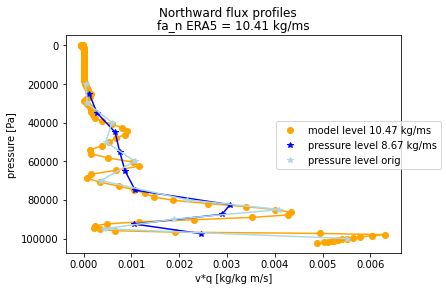

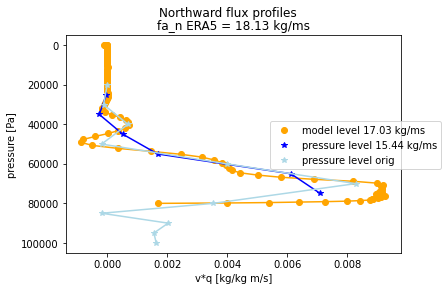

In [62]:
fig, axs = plt.subplots(1)
fig.suptitle('Northward flux profiles')

axs.plot(fa_n_ml_update[:,0,0],p_modellevels[:,0,0],'o', color= 'orange', label = 'model level '+ format(fa_n_ml[0,0].values,".2f") + ' kg/ms')
axs.plot(fa_n_ml_update[:,0,0],p_modellevels[:,0,0],'-', color= 'orange')
axs.plot(fa_n_pl_edges_update[:,0,0],edges*100,'*', color= 'blue', label ='pressure level '+ format(fa_n_pl_edges[0,0].values,".2f") + ' kg/ms')
axs.plot(fa_n_pl_edges_update[:,0,0],edges*100,'-', color= 'blue')
axs.plot(v_pl[:,0,0]*q_pl[:,0,0],levels*100,'*', color= 'lightblue', label ='pressure level orig')#
axs.plot(v_pl[:,0,0]*q_pl[:,0,0],levels*100,'-', color= 'lightblue')
axs.set_title('fa_n ERA5 = ' + format(vinwv[0,0].values,".2f") + ' kg/ms')
plt.gca().invert_yaxis()
axs.set_xlabel('v*q [kg/kg m/s]')
axs.set_ylabel('pressure [Pa]')
fig.legend(loc='center right')

fig1, axs1 = plt.subplots(1)
fig1.suptitle('Northward flux profiles')
axs1.plot(fa_n_ml_update[:,60,225],p_modellevels[:,60,225],'o', color= 'orange', label = 'model level '+ format(fa_n_ml[60,225].values,".2f") + ' kg/ms')
axs1.plot(fa_n_ml_update[:,60,225],p_modellevels[:,60,225],'-', color= 'orange')
axs1.plot(fa_n_pl_edges_update[:,60,225],edges*100,'*', color= 'blue', label ='pressure level '+ format(fa_n_pl_edges[60,225].values,".2f") + ' kg/ms')
axs1.plot(fa_n_pl_edges_update[:,60,225],edges*100,'-', color= 'blue')
axs1.plot(v_pl[:,60,225]*q_pl[:,60,225],levels*100,'*', color= 'lightblue', label ='pressure level orig')
axs1.plot(v_pl[:,60,225]*q_pl[:,60,225],levels*100,'-', color= 'lightblue')
axs1.set_title('fa_n ERA5 = ' + format(vinwv[60,225].values,".2f") + ' kg/ms')
plt.gca().invert_yaxis()
axs1.set_xlabel('v*q [kg/kg m/s]')
axs1.set_ylabel('pressure [Pa]')
fig1.legend(loc='center right')


In [60]:
v_pl

<xarray.DataArray 'v' (level: 11, latitude: 121, longitude: 321)>
[427251 values with dtype=float32]
Coordinates:
    time       datetime64[ns] 2013-05-21
  * longitude  (longitude) float32 -50.0 -49.75 -49.5 -49.25 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 30.5 30.25 30.0
  * level      (level) float64 200.0 300.0 400.0 500.0 ... 900.0 950.0 1e+03
Attributes:
    standard_name:  northward_wind
    long_name:      V component of wind
    units:          m s**-1